In [3]:
from googleapiclient.discovery import build
import pandas as pd
# from google.colab import files, drive   # only needed if we run the code in google colab
import getpass
import csv
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np


##### Collect the publication dates of the videos (if they were already collected go to next section)

In [3]:
# Will require a youtube API key 
api_key = getpass.getpass('Please enter your YouTube API key: ')
playlist_ids = ['PLKRyT68ziy5FMq-gYqsIpri_ln_k3a6ho']



In [4]:
with open('video_ids.csv', 'r') as file:
    reader = csv.reader(file)
    video_ids = [row[0] for row in reader]

In [23]:
print(video_ids[993])
print(len(video_ids))
print(type(video_ids[1006]))

yGhUSHZuoIw
1007
<class 'str'>


In [5]:
youtube = build('youtube', 'v3', developerKey=api_key)



In [6]:
def get_video_details_and_extract(video_ids, youtube):
    video_details = []
    # Split video_ids into chunks of 50 (API can handle a maximum of 50 video IDs per request)
    video_ids_chunks = [video_ids[i:i + 50] for i in range(0, len(video_ids), 50)]

    for chunk in video_ids_chunks:
        # Request video details for the current chunk
        request = youtube.videos().list(
            part='snippet',
            id=','.join(chunk)
        )
        response = request.execute()

        # Extract video_id and publishedAt from the response
        for item in response.get('items', []):
            video_id = item['id']
            published_at = item['snippet']['publishedAt']
            video_details.append({'video_id': video_id, 'publishedAt': published_at})

        # Handle pagination: if the response has a "nextPageToken", fetch the next page
        while 'nextPageToken' in response:
            page_token = response['nextPageToken']
            request = youtube.videos().list(
                part='snippet',
                id=','.join(chunk),
                pageToken=page_token
            )
            response = request.execute()

            for item in response.get('items', []):
                video_id = item['id']
                published_at = item['snippet']['publishedAt']
                video_details.append({'video_id': video_id, 'publishedAt': published_at})

    return video_details

In [7]:
video_details = get_video_details_and_extract(video_ids, youtube)
# [{'video_id': 'QiFsuF8sltA', 'publishedAt': '2020-04-23T04:52:02Z'}, ..., ] it is a list of ditionnaries

In [8]:
video_dates = []
for details in video_details:
    video_dates.append(details['publishedAt'].split('T')[0])

In [9]:
print(video_dates[10])

2020-04-03


In [10]:
video_dates_series = pd.Series(video_dates)


In [11]:
unique_video_dates_series = video_dates_series.drop_duplicates()

In [12]:
sorted_video_dates = unique_video_dates_series.sort_values()

In [13]:
date_series_without_first = sorted_video_dates.iloc[1:].reset_index(drop=True)


In [46]:
date_series_without_first

0      2019-10-05
1      2019-10-07
2      2019-10-08
3      2019-10-09
4      2019-10-10
          ...    
991    2024-12-05
992    2024-12-06
993    2024-12-09
994    2024-12-10
995    2024-12-11
Length: 996, dtype: object

In [21]:
date_series_without_first.to_csv('dates_output.csv', header=False)

##### If the dates of the videos were already collected, directly run this

In [4]:
df = pd.read_csv('dates_output.csv', header=None, names=['index', 'date'])

dates_series = pd.Series(df['date'].values)

dates_series = pd.to_datetime(dates_series)

final_series = pd.Series(dates_series.dt.date)

In [5]:

date_diff = final_series.diff()

# Identify gaps greater than 7 days
gaps = date_diff[date_diff > pd.Timedelta(days=5)]

In [7]:
start_date = final_series.iloc[0]
end_date = final_series.iloc[-1]

# Create a date range to fill all the missing values from the data
date_range = pd.date_range(start=start_date, end=end_date)

date_series = pd.Series(date_range)

In [9]:
# We won't take into account the comments written if there was no video that day, their number is going to be less 
dates_missing_videos = date_series[~date_series.isin(final_series)]

C:\Users\matth\AppData\Local\Temp\ipykernel_9924\1201904256.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dates_missing_videos = date_series[~date_series.isin(final_series)]


### Count the number of comments for each day 

In [10]:
comments_df = pd.read_csv('comments_data/labeled_data.csv')

comments_df['Timestamp'] = pd.to_datetime(comments_df['Timestamp'])

# Count the number of comments per day
comments_per_day = comments_df.groupby(comments_df['Timestamp'].dt.date).size()

# Convert the comments count to a DataFrame for easier merging
comments_count_df = comments_per_day.reset_index(name='comment_count')

comments_count_df['Timestamp'] = pd.to_datetime(comments_count_df['Timestamp'])

# Create a DataFrame with all dates in date_series
all_dates_df = pd.DataFrame({'Timestamp': date_series})

# Merge with comments_count_df to ensure all dates are present
comments_count_df = pd.merge(all_dates_df, comments_count_df, on='Timestamp', how='left')

# Fill missing comment_count values with 0
comments_count_df['comment_count'] = comments_count_df['comment_count'].fillna(0).astype(int)

# Merge the positive_labels_count into the comments_count_df (using 'Timestamp' as the key)
comments_count_df = comments_count_df.set_index('Timestamp')

# Reset index to restore the original DataFrame structure
comments_count_df = comments_count_df.reset_index()

# Ensure comments_count_df only includes rows for the dates in date_series
comments_count_df = comments_count_df[comments_count_df['Timestamp'].isin(date_series)]

# Set comment_count and positive_labels to 0 for missing video dates (dates where no video was published)
comments_count_df.loc[comments_count_df['Timestamp'].isin(dates_missing_videos), 'comment_count'] = 0


# Replace zeros in 'comment_count' and 'positive_labels' iteratively by the average of the previous 7 days
comment_counts = comments_count_df['comment_count'].tolist()

def replace_zeros_with_average(data, start_index=7):
    for i in range(len(data)):
        if data[i] == 0:
            if i >= start_index:
                # Replace with the average of the previous 7 days
                data[i] = sum(data[i - start_index:i]) // start_index
            elif i > 0:
                # For the first few rows, replace with the previous non-zero value
                data[i] = data[i - 1]
    return data

comment_counts = replace_zeros_with_average(comment_counts)

comments_count_df['comment_count'] = comment_counts





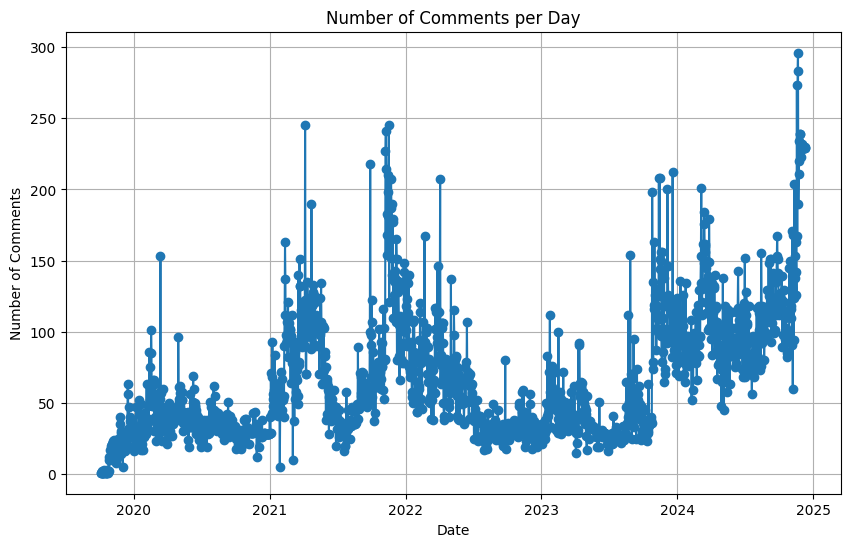

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df.comment_count, marker='o', linestyle='-')
plt.title('Number of Comments per Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()


In [12]:
comments_count_df = comments_count_df.sort_values(by='Timestamp')

# Calculate the 7-day rolling average of comment_count
comments_count_df['7_days_average'] = comments_count_df['comment_count'].rolling(window=7, min_periods=1).mean()

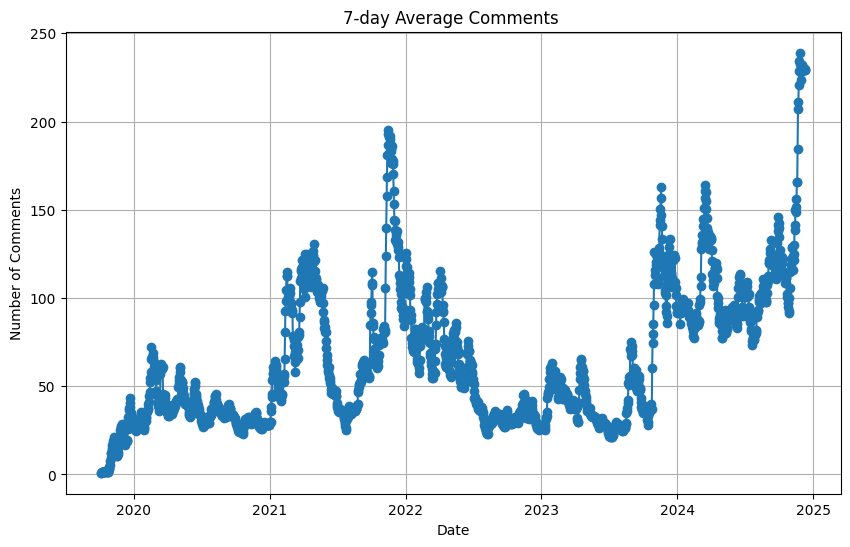

In [13]:

plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df['7_days_average'], marker='o', linestyle='-')
plt.title('7-day Average Comments ')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()

In [14]:
comments_count_df = comments_count_df.sort_values(by='Timestamp')

# Calculate the 30-day rolling average of comment_count
comments_count_df['30_days_average'] = comments_count_df['comment_count'].rolling(window=30, min_periods=1).mean()

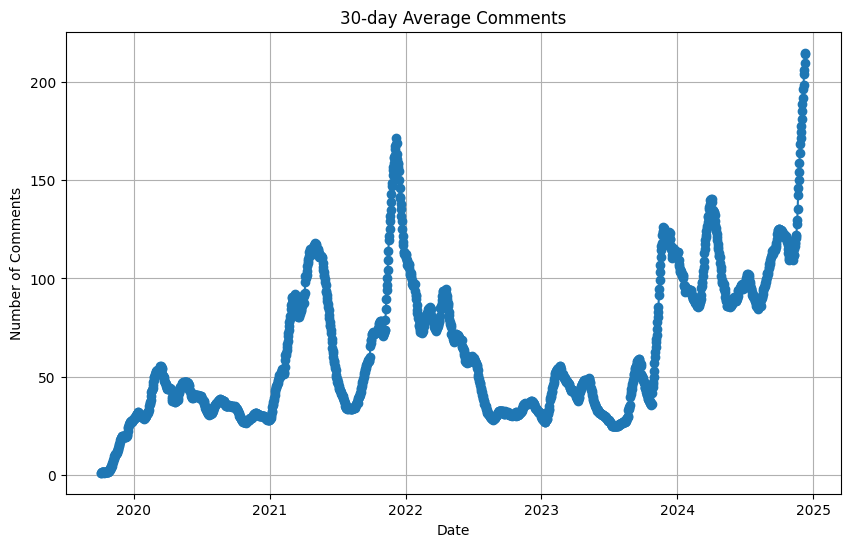

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df['30_days_average'], marker='o', linestyle='-')
plt.title('30-day Average Comments')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()

##### Visualizations with bitcoin price

In [16]:
btc_df = pd.read_csv('bitcoin_data.csv')

In [17]:
btc_df.head(1)

,Date,Open,Close
0,2019-10-05,8210.149414,8151.500488


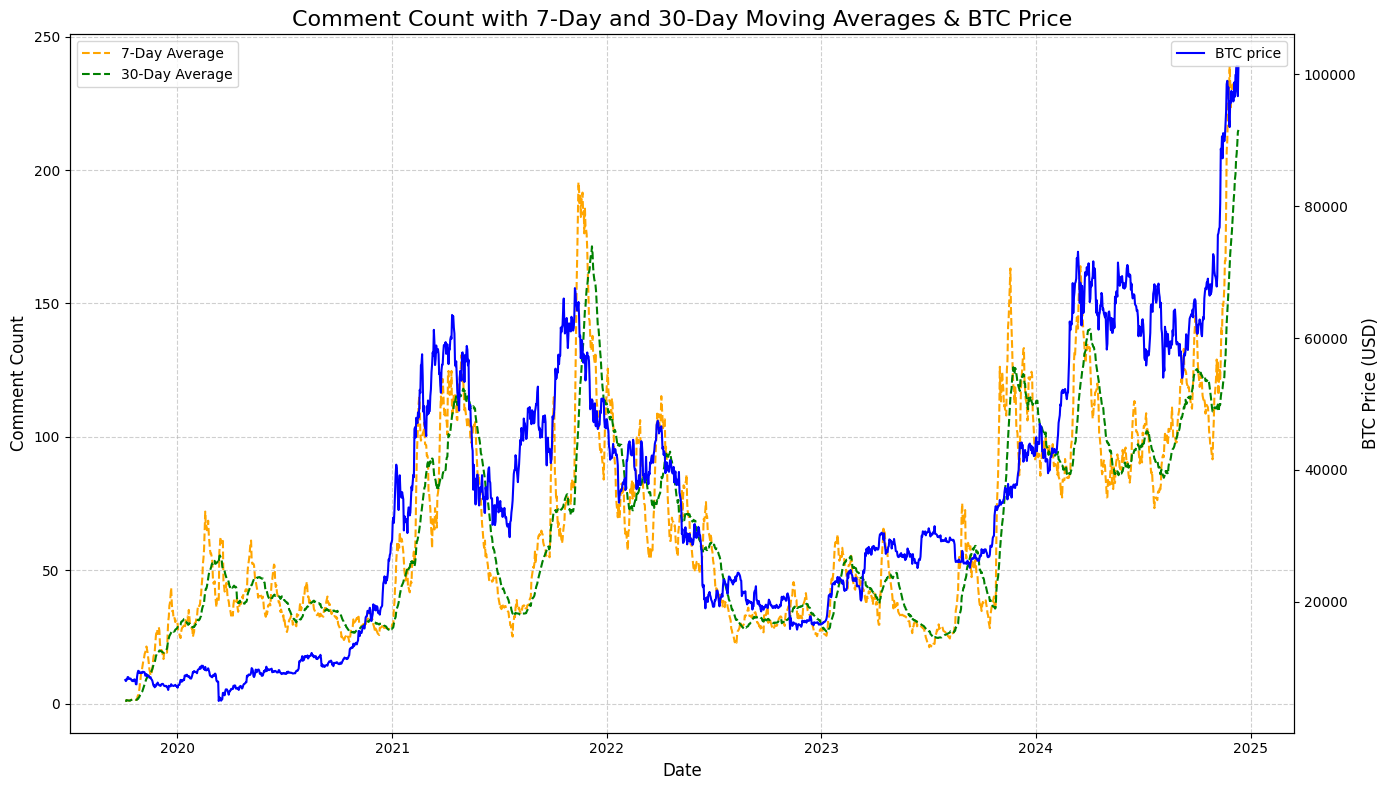

In [18]:

btc_df['Date'] = pd.to_datetime(btc_df['Date'])

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the comment count and moving averages on the left y-axis
#ax1.plot(comments_count_df['Timestamp'], comments_count_df['comment_count'], label='Daily Comment Count', color='blue', linewidth=1)
ax1.plot(comments_count_df['Timestamp'], comments_count_df['7_days_average'], label='7-Day Average', color='orange', linestyle='--')
ax1.plot(comments_count_df['Timestamp'], comments_count_df['30_days_average'], label='30-Day Average', color='green', linestyle='--')

# Set labels for the left y-axis
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Comment Count', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for the BTC price
ax2 = ax1.twinx()

# Plot the BTC price on the right y-axis
ax2.plot(btc_df['Date'], btc_df['Close'], label='BTC price', color='blue', linestyle='-')

# Set labels for the right y-axis
ax2.set_ylabel('BTC Price (USD)', fontsize=12)
ax2.legend(loc='upper right')

# Add titles and adjust layout
plt.title('Comment Count with 7-Day and 30-Day Moving Averages & BTC Price', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


### Counting the percentage of positive comments 

In [19]:
df_filtered_label_1 = comments_df[comments_df['label'] == 1]


# Group by the Timestamp column and count the number of positive labels
labels_count_df = df_filtered_label_1.groupby(comments_df['Timestamp'].dt.date).size().reset_index(name='label_count')

labels_count_df['Timestamp'] = pd.to_datetime(labels_count_df['Timestamp'])

# Merge with label_count_df to ensure all dates are present, using 'left' join
labels_count_df = pd.merge(all_dates_df, labels_count_df, on='Timestamp', how='left')

# Set label_count to 0 for missing video dates (dates where no video was published)
labels_count_df.loc[labels_count_df['Timestamp'].isin(dates_missing_videos), 'label_count'] = 0

# Fill missing comment_count values with 0
labels_count_df['label_count'] = labels_count_df['label_count'].fillna(0).astype(int)

# Replace zeros in 'label_count' iteratively by the average of the previous 7 days
label_counts = labels_count_df['label_count'].tolist()

# Apply the function to label_count columns
label_counts = replace_zeros_with_average(label_counts)

# Update the DataFrame with the new values 
labels_count_df['label_count'] = label_counts

In [20]:
comments_count_df['label_count'] = label_counts

comments_count_df['percent_positive_labels'] = comments_count_df['label_count'] / comments_count_df['comment_count']

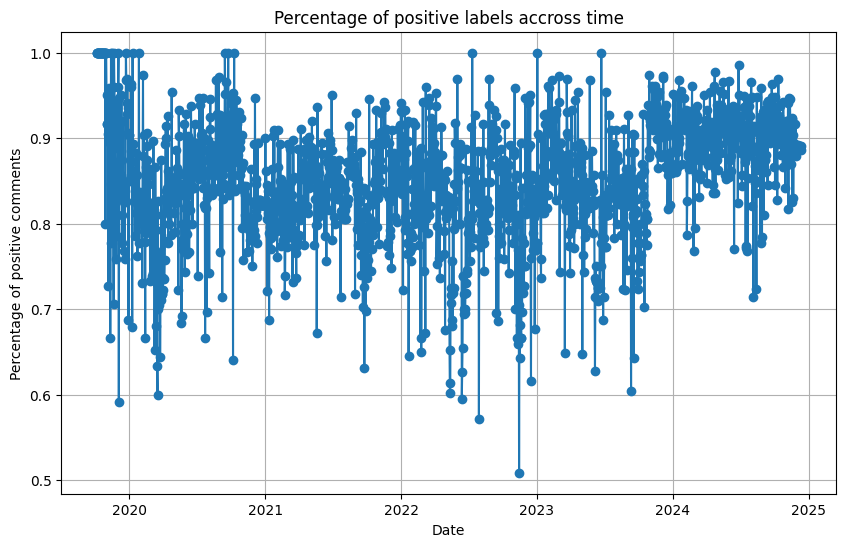

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df['percent_positive_labels'], marker='o', linestyle='-')
plt.title('Percentage of positive labels accross time')
plt.xlabel('Date')
plt.ylabel('Percentage of positive comments')
plt.grid(True)
plt.show()

In [22]:
comments_count_df = comments_count_df.sort_values(by='Timestamp')

# Calculate the 7-day rolling average of comment_count
comments_count_df['7_days_labels_average'] = comments_count_df['label_count'].rolling(window=7, min_periods=1).mean()

comments_count_df['7_days_labels_percentage'] = comments_count_df['7_days_labels_average'] / comments_count_df['7_days_average']



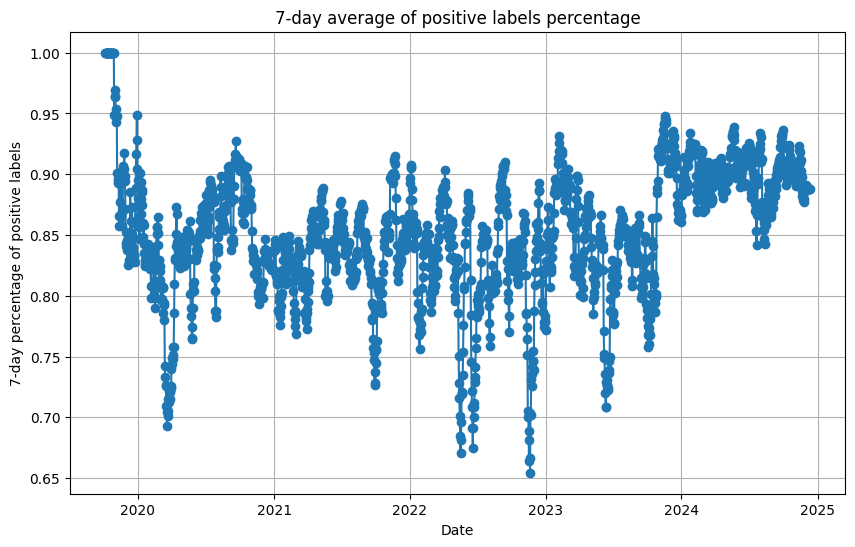

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df['7_days_labels_percentage'], marker='o', linestyle='-')
plt.title('7-day average of positive labels percentage')
plt.xlabel('Date')
plt.ylabel('7-day percentage of positive labels')
plt.grid(True)
plt.show()

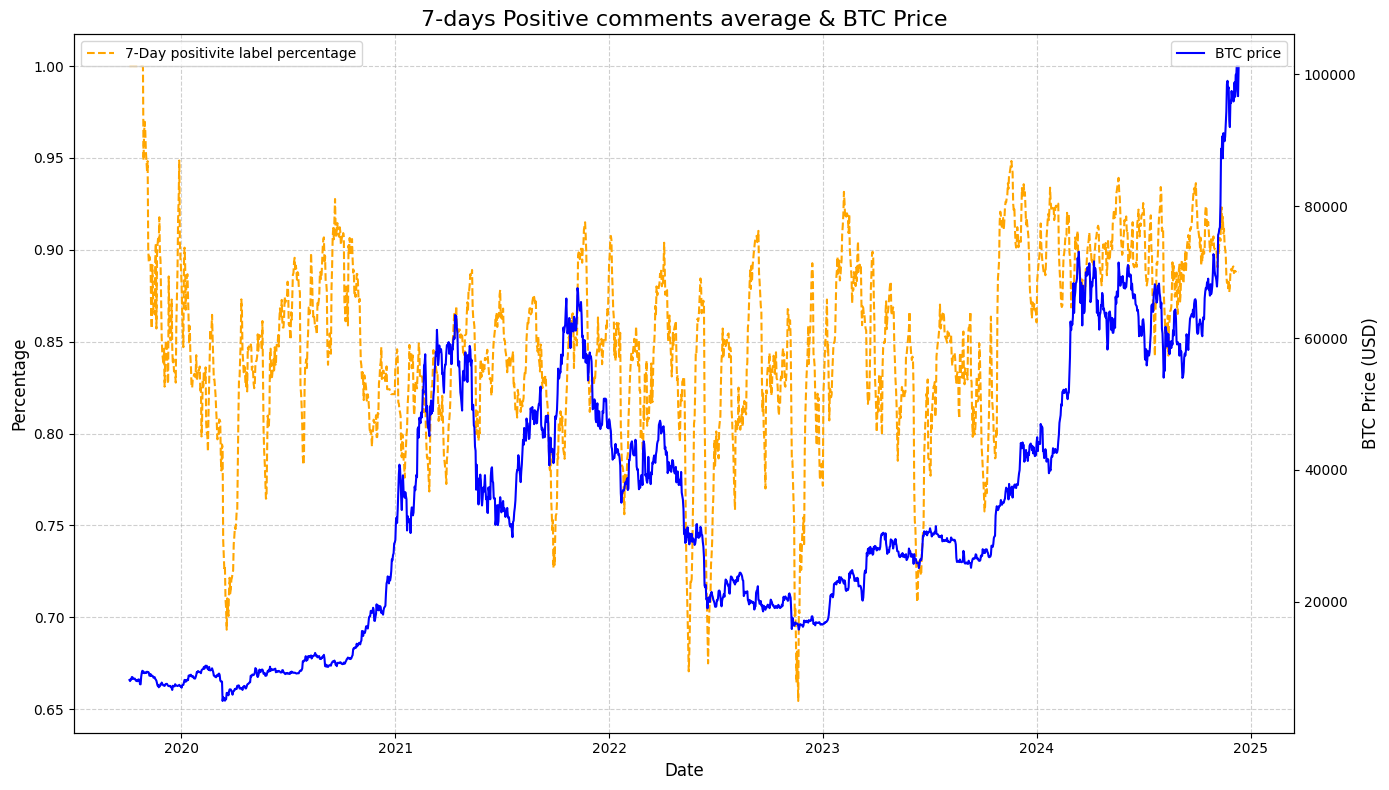

In [24]:
btc_df['Date'] = pd.to_datetime(btc_df['Date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the comment count and moving averages on the left y-axis
ax1.plot(comments_count_df['Timestamp'], comments_count_df['7_days_labels_percentage'], label='7-Day positivite label percentage', color='orange', linestyle='--')


# Set labels for the left y-axis
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Percentage', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for the BTC price
ax2 = ax1.twinx()

# Plot the BTC price on the right y-axis
ax2.plot(btc_df['Date'], btc_df['Close'], label='BTC price', color='blue', linestyle='-')

# Set labels for the right y-axis
ax2.set_ylabel('BTC Price (USD)', fontsize=12)
ax2.legend(loc='upper right')

# Add titles and adjust layout
plt.title('7-days Positive comments average & BTC Price', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
# Calculate the 30-day rolling average of comment_count
comments_count_df['30_days_labels_average'] = comments_count_df['label_count'].rolling(window=30, min_periods=1).mean()

comments_count_df['30_days_labels_percentage'] = comments_count_df['30_days_labels_average'] / comments_count_df['30_days_average']

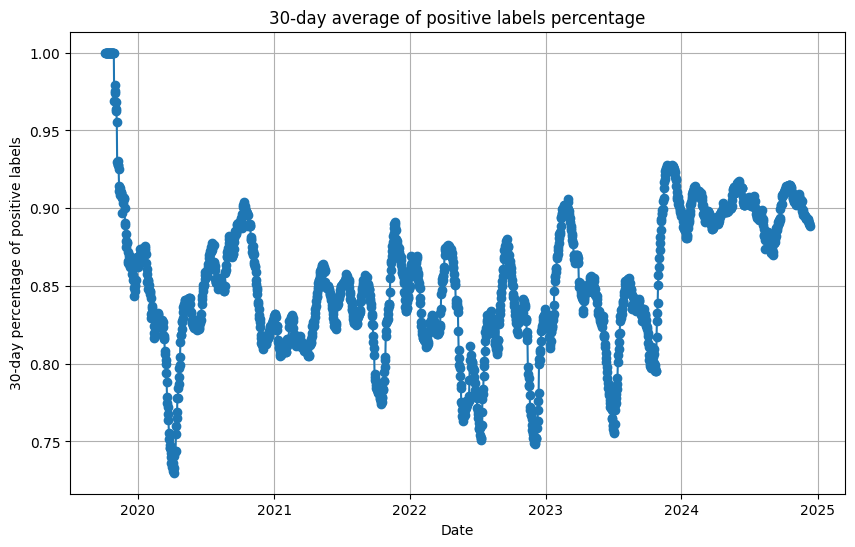

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df.Timestamp, comments_count_df['30_days_labels_percentage'], marker='o', linestyle='-')
plt.title('30-day average of positive labels percentage')
plt.xlabel('Date')
plt.ylabel('30-day percentage of positive labels')
plt.grid(True)
plt.show()

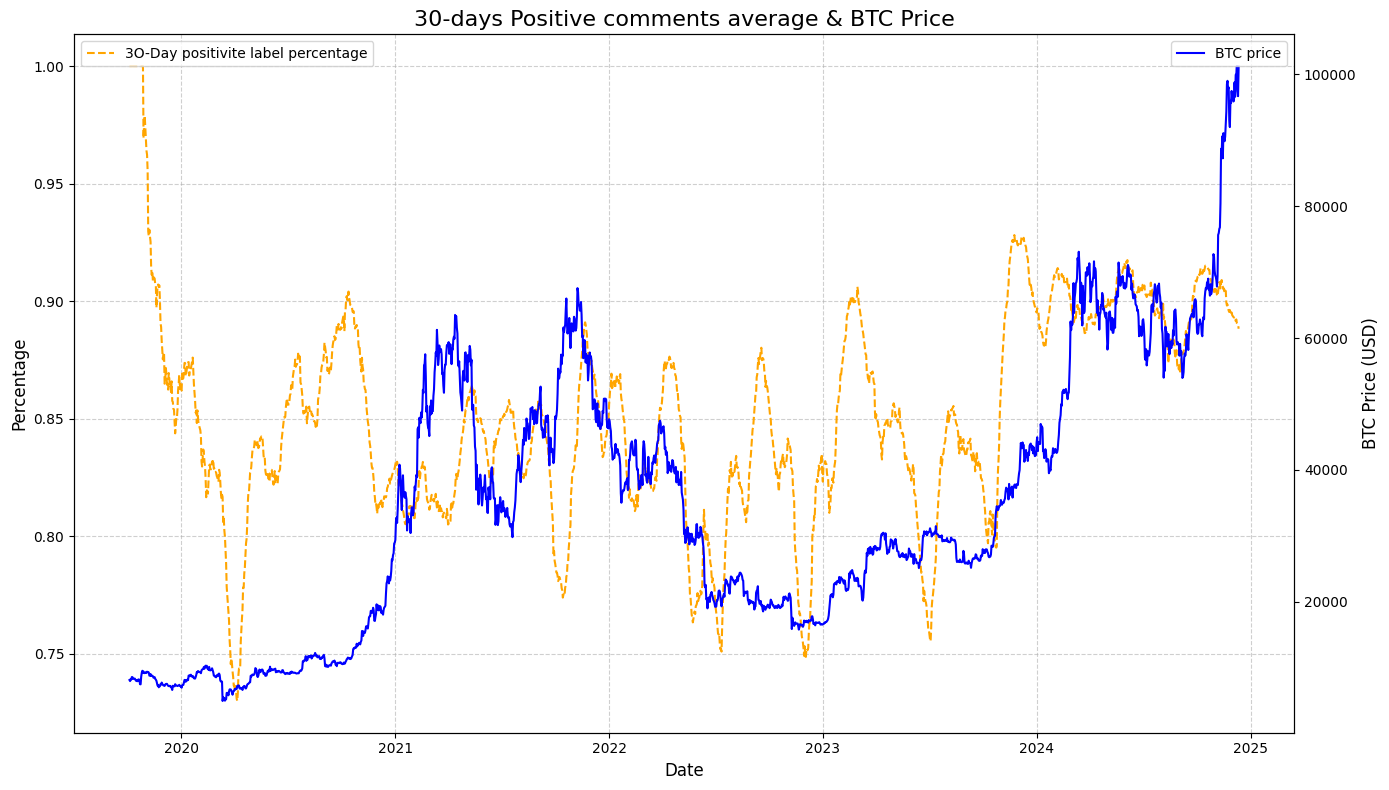

In [27]:
# Ensure the 'Date' column in btc_df is of datetime type
btc_df['Date'] = pd.to_datetime(btc_df['Date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the comment count and moving averages on the left y-axis
ax1.plot(comments_count_df['Timestamp'], comments_count_df['30_days_labels_percentage'], label='3O-Day positivite label percentage', color='orange', linestyle='--')


# Set labels for the left y-axis
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Percentage', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for the BTC price
ax2 = ax1.twinx()

# Plot the BTC price on the right y-axis
ax2.plot(btc_df['Date'], btc_df['Close'], label='BTC price', color='blue', linestyle='-')

# Set labels for the right y-axis
ax2.set_ylabel('BTC Price (USD)', fontsize=12)
ax2.legend(loc='upper right')

# Add titles and adjust layout
plt.title('30-days Positive comments average & BTC Price', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

##### Creation of the fear and greed indicator 

The indicator will be based on two observations :
-

Pente (m): 0.03448755869193771
Ordonnée à l'origine (b): 30.71318623346704
Coefficient de corrélation (R): 0.5154128059055886
P-value: 4.2423116123318204e-129
Erreur standard: 0.001317902809496889


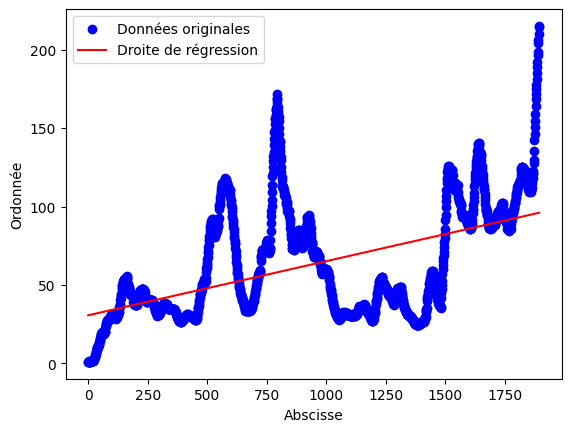

In [28]:
# Define a reference date
reference_date = comments_count_df['Timestamp'].min()

x = (comments_count_df['Timestamp'] - reference_date).dt.days
y_30 = comments_count_df['30_days_average']
y_7 = comments_count_df['7_days_average']


# Effectuer la régression linéaire
slope_30, intercept_30, r_value_30, p_value_30, std_err_30 = linregress(x, y_30)
slope_7, intercept_7, r_value_7, p_value_7, std_err7_ = linregress(x, y_7)

# Afficher les résultats
print(f"Pente (m): {slope_30}")
print(f"Ordonnée à l'origine (b): {intercept_30}")
print(f"Coefficient de corrélation (R): {r_value_30}")
print(f"P-value: {p_value_30}")
print(f"Erreur standard: {std_err_30}")

# Tracer la courbe originale et la droite de régression
plt.scatter(x, y_30, color='blue', label='Données originales')
plt.plot(x, slope_30 * x + intercept_30, color='red', label='Droite de régression')
plt.xlabel('Abscisse')
plt.ylabel('Ordonnée')
plt.legend()
plt.show()

In [29]:
comments_count_df['Growing_mean_comments_30'] = (slope_30+0.001)*comments_count_df.index + intercept_30
comments_count_df['Growing_mean_comments_7'] = slope_7*comments_count_df.index + intercept_7

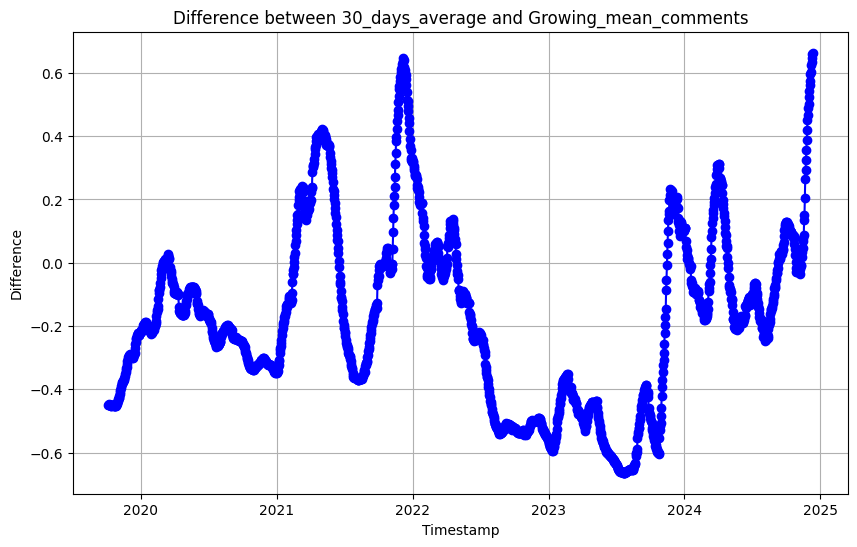

In [31]:
values_30 = comments_count_df['30_days_average'] - comments_count_df['Growing_mean_comments_30']
values_7 = comments_count_df['7_days_average'] - comments_count_df['Growing_mean_comments_7']

# bound the result
scaling_factor = 0.01
bounded_values_tanh_30 = np.tanh(scaling_factor * values_30) - ((np.tanh(scaling_factor * values_30)).max() + (np.tanh(scaling_factor * values_30)).min())/2
bounded_values_tanh_7 = np.tanh(scaling_factor * values_7) - ((np.tanh(scaling_factor * values_7)).max() + (np.tanh(scaling_factor * values_7)).min())/2


# Line plot
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df['Timestamp'], bounded_values_tanh_30, marker='o', linestyle='-', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Difference')
plt.title('Difference between 30_days_average and Growing_mean_comments')
plt.grid(True)
plt.show()

In [32]:
comments_count_df['30-day index'] = 1000*(bounded_values_tanh_30.abs() * (comments_count_df['30_days_labels_percentage'] - (comments_count_df['30_days_labels_percentage']-0.0275).mean() ))
comments_count_df['7-day index'] = 1000*(bounded_values_tanh_7.abs() * (comments_count_df['7_days_labels_percentage'] - (comments_count_df['7_days_labels_percentage']-0.0275).mean() ))


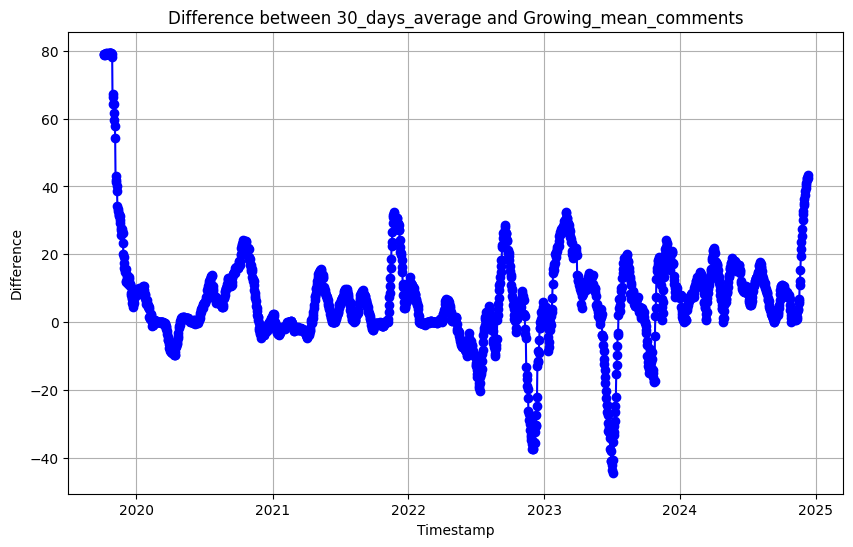

In [33]:
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df['Timestamp'], comments_count_df['30-day index'], marker='o', linestyle='-', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Difference')
plt.title('Difference between 30_days_average and Growing_mean_comments')
plt.grid(True)
plt.show()

In [34]:
comments_count_df[comments_count_df['30-day index'] == comments_count_df['30-day index'].min()]['Timestamp']

1368   2023-07-04
Name: Timestamp, dtype: datetime64[ns]

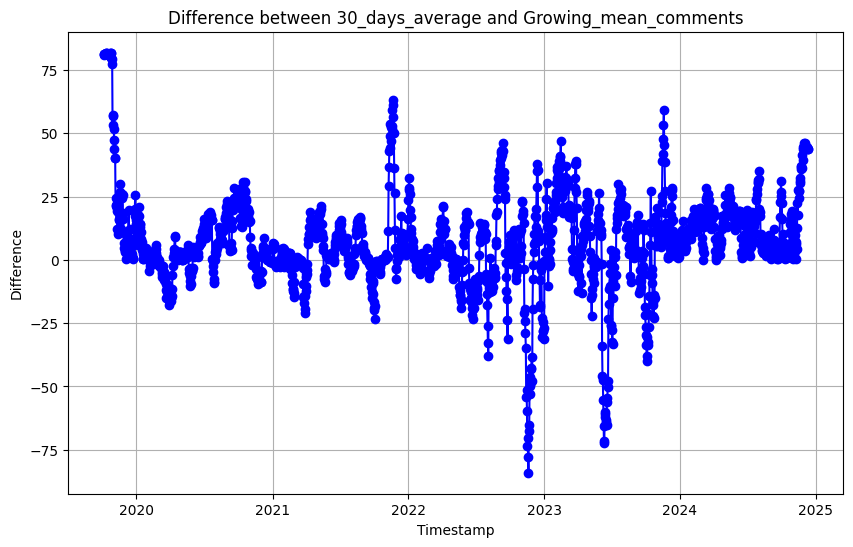

In [35]:
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(comments_count_df['Timestamp'], comments_count_df['7-day index'], marker='o', linestyle='-', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Difference')
plt.title('Difference between 30_days_average and Growing_mean_comments')
plt.grid(True)
plt.show()

In [36]:
comments_count_df[(comments_count_df['30-day index'] > 20) & (comments_count_df['Timestamp'] > '2023-01-01') & ('2024-01-01' > comments_count_df['Timestamp'] )]['Timestamp']

1214   2023-01-31
1216   2023-02-02
1217   2023-02-03
1218   2023-02-04
1219   2023-02-05
          ...    
1525   2023-12-08
1526   2023-12-09
1527   2023-12-10
1528   2023-12-11
1529   2023-12-12
Name: Timestamp, Length: 68, dtype: datetime64[ns]